In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

from mergeplg import interpolate, merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

# Fix error where lat/lon was set to variable
ds_rad = ds_rad.set_coords(["longitudes", "latitudes"])
ds_rad = ds_rad.rename({"rainfall_amount": "rainfall_radar"})

# Fix naming errors
ds_gauges = ds_gauges.rename({"station_id": "id", "rainfall_amount": "R"})
ds_gauges_smhi = ds_gauges_smhi.rename({"station_id": "id", "rainfall_amount": "R"})
ds_rad = ds_rad.rename({"longitudes": "lon", "latitudes": "lat"})

In [4]:
# Threshold lower values, nan is ignored in functions
radar_zero = 0.01  # here in sum mm over 5 minutes
ds_rad["rainfall_radar"] = xr.where(
    ds_rad.rainfall_radar > radar_zero, ds_rad.rainfall_radar, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

# Estimate rainfall fields

In [9]:
# Define variogram parameters used by kriging
variogram_parameters = {"sill": 1, "range": 30000, "nugget": 0.3}
variogram_model = "spherical"

# Number of neighbours to use for interpolation
nnear = 8

In [10]:
# Simple model for assigning uncertainty to every observation,
# this example assigns more uncertainty to low rainfall rates.
ds_cmls["sigma_R"] = 0.3 * np.exp(-ds_cmls["R"] / 0.5)

## Interpolate ground observations

### IDW interpolation

In [11]:
interpolator = interpolate.InterpolateIDW(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_interpolateIDW"] = xr.concat(rainfall, dim="time")

### Kriging interpolation

In [12]:
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
            # da_cmls_sigma=ds_cmls.sigma_R.sel(time = time),
        )
    )
ds_rad["rainfall_interpolateBKpoint"] = xr.concat(rainfall, dim="time")

### Block kriging interpolation

In [13]:
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.R.sel(time=time),
            # da_cmls_sigma=ds_cmls.sigma_R.sel(time = time),
        )
    )
ds_rad["rainfall_interpolateBKline"] = xr.concat(rainfall, dim="time")

## Adjust radar field

### IDW additive adjust

In [14]:
merger = merge.MergeDifferenceIDW(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    method="additive",
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            da_rad=ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.R.sel(time=time),
        )
    )
ds_rad["rainfall_additiveIDW"] = xr.concat(rainfall, dim="time")

### Kriging additive adjust

In [15]:
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=False,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_additiveBKpoint"] = xr.concat(rainfall, dim="time")

### Block kriging additive adjust

In [16]:
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    full_line=True,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
    method="additive",
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_additiveBKline"] = xr.concat(rainfall, dim="time")

### Block kriging with external drift

In [17]:
merger = merge.MergeKrigingExternalDrift(
    ds_rad=ds_rad.rainfall_radar,
    ds_cmls=ds_cmls,
    variogram_parameters=variogram_parameters,
    nnear=nnear,
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
        )
    )
ds_rad["rainfall_KED"] = xr.concat(rainfall, dim="time")

### Set nan equal to 0

In [18]:
# Set nan equal to 0
rainfall_fields = [
    "rainfall_radar",
    "rainfall_interpolateIDW",
    "rainfall_interpolateBKpoint",
    "rainfall_interpolateBKline",
    "rainfall_additiveIDW",
    "rainfall_additiveBKpoint",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

for rainfall_field in rainfall_fields:
    ds_rad[rainfall_field] = xr.where(
        np.isnan(ds_rad[rainfall_field]), 0, ds_rad[rainfall_field]
    )

# Plot rainfall fields

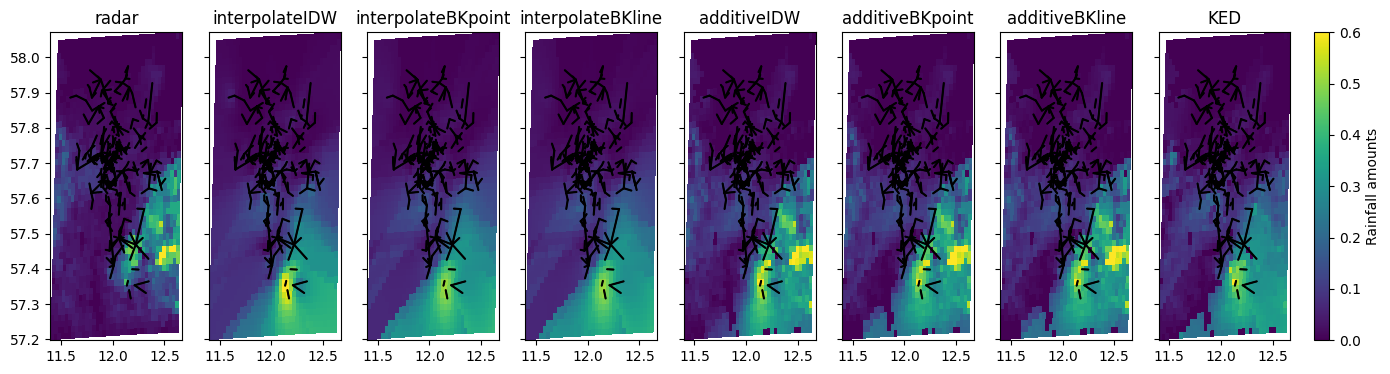

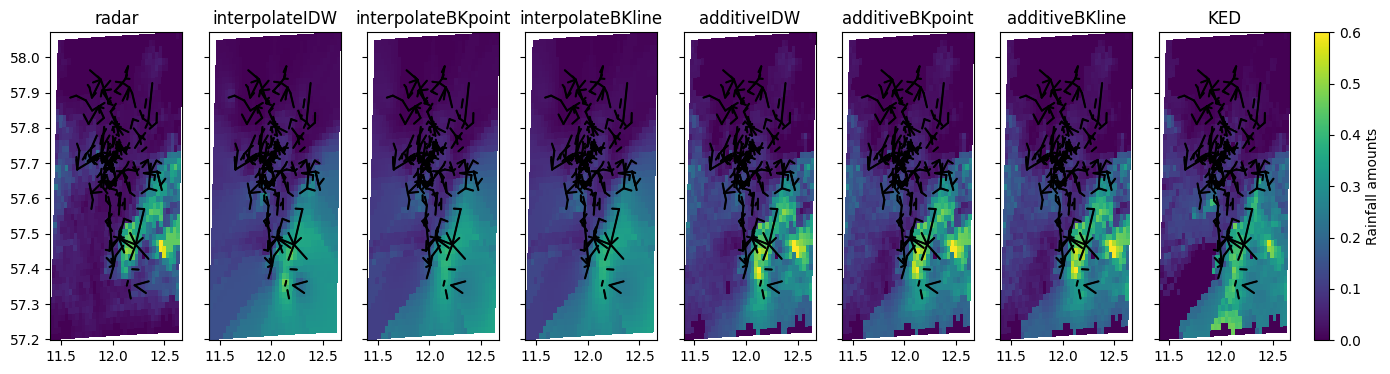

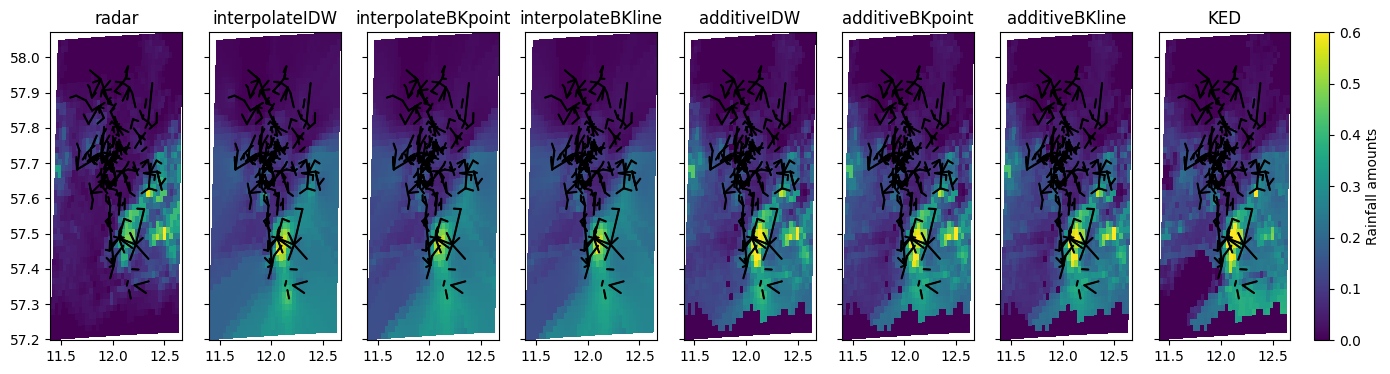

In [19]:
vmax = 0.6  # max color
cmap_rain = "viridis"
# Time interval to plot
time_start = "2015-07-25T12:30"
time_end = "2015-07-25T13:30"

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_interpolateIDW",
    "rainfall_interpolateBKpoint",
    "rainfall_interpolateBKline",
    "rainfall_additiveIDW",
    "rainfall_additiveBKpoint",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

for time in ds_cmls.sel(time=slice(time_start, time_end)).time[:3]:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad.lon,
            ds_rad.lat,
            ds_rad[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap=cmap_rain,
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls,
            use_lon_lat=True,
            ax=ax[i],
            line_color="k",
        )

        ax[i].set_title(rainfall_field.split("_")[1])

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall amounts")
    plt.show()

# Compare adjusted fields to CML observations

In [20]:
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.lon.data,
    y_grid=ds_rad.lat.data,
    grid_point_location="center",
)

rainfall_fields = [
    "rainfall_radar",
    "rainfall_interpolateIDW",
    "rainfall_interpolateBKpoint",
    "rainfall_interpolateBKline",
    "rainfall_additiveIDW",
    "rainfall_additiveBKpoint",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

# Sample CML along line
for rainfall_field in rainfall_fields:
    ds_cmls[rainfall_field] = plg.spatial.get_grid_time_series_at_intersections(
        grid_data=ds_rad[rainfall_field],
        intersect_weights=intersect_weights,
    )

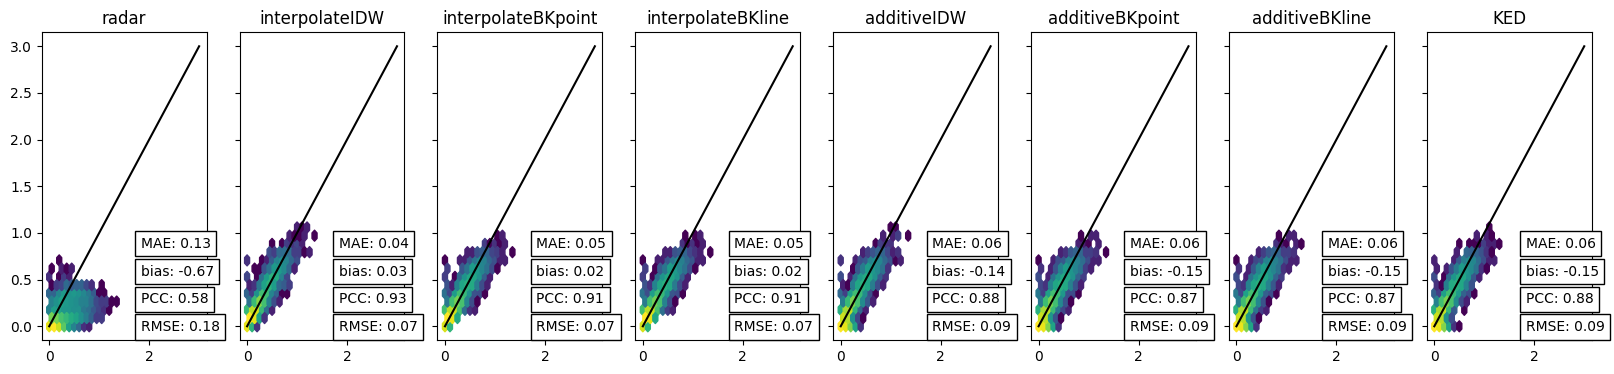

In [21]:
# Plot
vmax = 3
threshold = 0  # Only use above
extent = [0, vmax, 0, vmax]
gridsize = 30
cml_observed = ds_cmls.R.data.ravel()
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)

for i, rainfall_field in enumerate(rainfall_fields):
    cml_estimate = ds_cmls[rainfall_field].data.ravel()

    ax[i].hexbin(
        cml_observed,
        cml_estimate,
        mincnt=1,
        extent=extent,
        gridsize=gridsize,
        bins="log",
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((cml_observed - cml_estimate) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(cml_observed, cml_estimate)[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(cml_estimate - cml_observed) / np.mean(cml_observed), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(cml_estimate - cml_observed)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(rainfall_field.split("_")[1])

# Compare adjusted fields to city rain gauges

In [22]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges.R,
    )

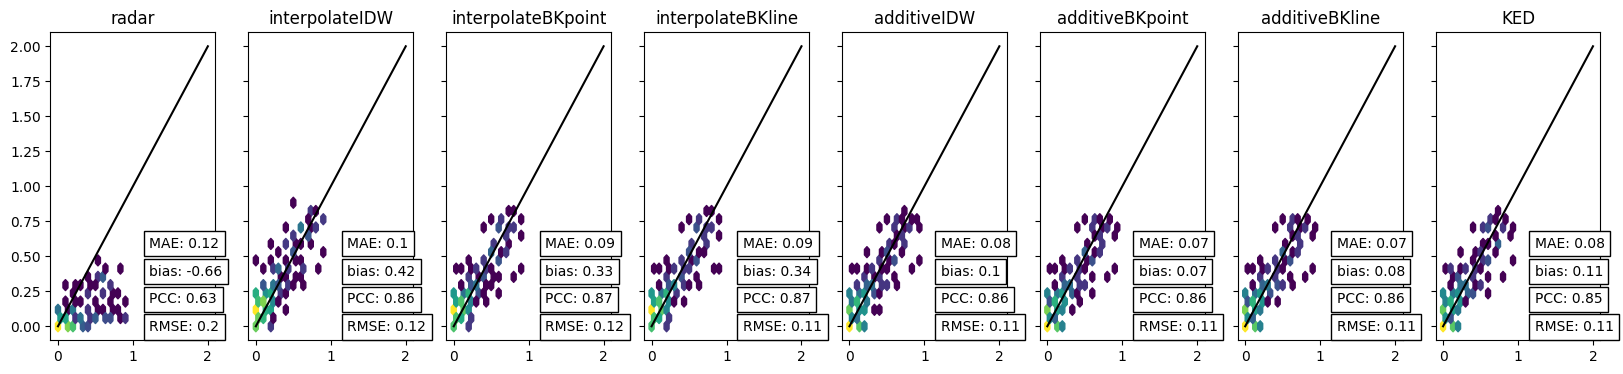

In [23]:
# Plot
vmax = 2
threshold = 0  # Only use above
extent = [0, vmax, 0, vmax]
gridsize = 30

gauge_observed = ds_gauges.R.data.ravel()
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    gauge_estimate = ds_gauges[rainfall_field].data.ravel()

    ax[i].hexbin(
        gauge_observed,
        gauge_estimate,
        mincnt=1,
        extent=extent,
        gridsize=gridsize,
        bins="log",
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: "
        + str(round(np.sqrt(np.mean((gauge_observed - gauge_estimate) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(gauge_observed, gauge_estimate)[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(
            round(np.mean(gauge_estimate - gauge_observed) / np.mean(gauge_observed), 2)
        ),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(gauge_estimate - gauge_observed)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(rainfall_field.split("_")[1])

# Compare to SMHI rain gauge

In [24]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges_smhi,
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges_smhi[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges_smhi.R,
    )

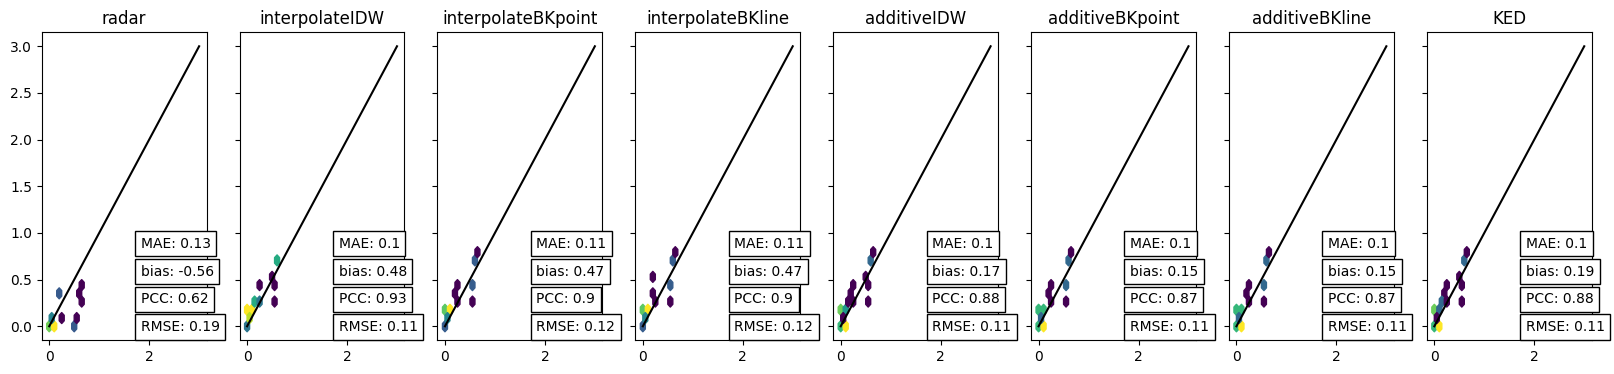

In [25]:
# Plot
vmax = 3
threshold = 0  # Only use above
extent = [0, vmax, 0, vmax]
gridsize = 30

gauge_observed = ds_gauges_smhi.R.data.ravel()
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    gauge_estimate = ds_gauges_smhi[rainfall_field].data.ravel()

    ax[i].hexbin(
        gauge_observed,
        gauge_estimate,
        mincnt=1,
        extent=extent,
        gridsize=gridsize,
        bins="log",
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: "
        + str(round(np.sqrt(np.mean((gauge_observed - gauge_estimate) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(gauge_observed, gauge_estimate)[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(
            round(np.mean(gauge_estimate - gauge_observed) / np.mean(gauge_observed), 2)
        ),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(gauge_estimate - gauge_observed)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(rainfall_field.split("_")[1])